<a href="https://colab.research.google.com/github/componavt/volcano_wikidata/blob/main/src/cluster_max_diameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clustering of Volcanoes and Earthquakes 🌋🌍

Алгоритм:
Во внешнем цикле меняется не максимальное расстояние между двумя элементами кластера, а максимальный разрешённый диаметр кластера.

In [1]:
# Input parameters
LANGUAGE = 'ru'  # 'en' or 'ru'

f_volcano = "volcanoes_2025.csv"
f_earthquake = "earthquakes_2025.csv"

# --- New clustering by max diameter ---
#cluster_diameter_max_list = list(range(10, 250, 10)) + [127]
cluster_diameter_max_list = list(range(10, 120, 10)) + [127] + list(range(130, 250, 10))

# --- Distance thresholds to explore ---
# dist_max = 100  # maximum distance (km) between volcano and earthquake to draw a line

# distances_max_list = range(10, 250, 10)  # Test thresholds from 10 km to 250 km
# distances_max_list = range(30, 150, 10)
distances_max_list = list(range(30, 80, 10)) + list(range(80, 100, 1)) + list(range(100, 150, 10)) # slow real
# distances_max_list = list(range(30, 80, 20)) + list(range(80, 100, 5)) + list(range(100, 150, 20)) # fast

# шаг 10 для диапазона 80-170, но шаг 2 для диапазона 120-130, чтобы увидеть на графике локальный изгиб
# [80, 90, 100, 110, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 140, 150, 160]
#distances_max_list = list(range(80, 120, 10)) + list(range(120, 130, 1)) + list(range(130, 170, 10))

# fast: шаг 40 для диапазона 80-170, но шаг 5 для диапазона 120-130, чтобы увидеть на графике локальный изгиб
# [80, 120, 127, 128, 130, 170]
#distances_max_list = list(range(80, 121, 40)) + [125] + list(range(127, 129, 1)) + list(range(130, 171, 40))
#distances_max_list = list(range(80, 121, 40))          + list(range(127, 129, 1)) + list(range(130, 171, 40))

print(distances_max_list)

[30, 40, 50, 60, 70, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 110, 120, 130, 140]


In [2]:
import csv
import numpy as np
from geopy.distance import geodesic
from scipy.spatial import KDTree
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import folium
# import pprint # Pretty Print for objects


# Download CSV files from GitHub
!wget https://raw.githubusercontent.com/componavt/volcano_wikidata/master/data/$f_volcano
!wget https://raw.githubusercontent.com/componavt/volcano_wikidata/master/data/$f_earthquake

!head -n 3 $f_volcano
!head -n 3 $f_earthquake

--2025-05-02 20:46:28--  https://raw.githubusercontent.com/componavt/volcano_wikidata/master/data/volcanoes_2025.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168392 (164K) [text/plain]
Saving to: ‘volcanoes_2025.csv’

volcanoes_2025.csv  100%[===================>] 164.45K  --.-KB/s    in 0.02s   

2025-05-02 20:46:29 (7.30 MB/s) - ‘volcanoes_2025.csv’ saved [168392/168392]

--2025-05-02 20:46:29--  https://raw.githubusercontent.com/componavt/volcano_wikidata/master/data/earthquakes_2025.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 

# 📏 Computing the Maximum Diameter of a Group

In [3]:
from geopy.distance import geodesic

def compute_group_diameter(group_coords):
    max_distance = 0
    n = len(group_coords)
    for i in range(n):
        for j in range(i+1, n):
            d = geodesic(group_coords[i], group_coords[j]).km
            if d > max_distance:
                max_distance = d
    return max_distance

# 📉 Compresses scale before 120, 📈 stretches 120-130, 📉 compresses after 130.

In [4]:
def transform_x(x, compress_before=0.5, compress_between=2.0, compress_after=0.5):
    """
    Transforms the input distance x with different compression ratios for different intervals.

    Parameters:
        x (float): Input distance value to be transformed
        compress_before (float): Compression factor for x < 120 (default: 0.5)
        compress_between (float): Compression/stretch factor for 120 <= x <= 130 (default: 2.0)
        compress_after (float): Compression factor for x > 130 (default: 0.5)

    Returns:
        float: Transformed value of x according to the specified compression rules

    Behavior:
        - For x < 120: applies compress_before multiplier (compression if < 1.0)
        - For 120-130: applies compress_between multiplier (stretches if > 1.0)
        - For x > 130: applies compress_after multiplier (compression if < 1.0)
    """
    if x < 120:
        return x * compress_before  # Compress region before 120 km
    elif 120 <= x <= 130:
        return 120 * compress_before + (x - 120) * compress_between  # Transform 120-130 km region
    else:
        return (120 * compress_before + 10 * compress_between) + (x - 130) * compress_after  # Compress region after 130 km

[1/24] Diameter max = 10 км
[2/24] Diameter max = 20 км
[3/24] Diameter max = 30 км
[4/24] Diameter max = 40 км
[5/24] Diameter max = 50 км
[6/24] Diameter max = 60 км
[7/24] Diameter max = 70 км
[8/24] Diameter max = 80 км
[9/24] Diameter max = 90 км
[10/24] Diameter max = 100 км
[11/24] Diameter max = 110 км
[12/24] Diameter max = 127 км
[13/24] Diameter max = 130 км
[14/24] Diameter max = 140 км
[15/24] Diameter max = 150 км
[16/24] Diameter max = 160 км
[17/24] Diameter max = 170 км
[18/24] Diameter max = 180 км
[19/24] Diameter max = 190 км
[20/24] Diameter max = 200 км
[21/24] Diameter max = 210 км
[22/24] Diameter max = 220 км
[23/24] Diameter max = 230 км
[24/24] Diameter max = 240 км


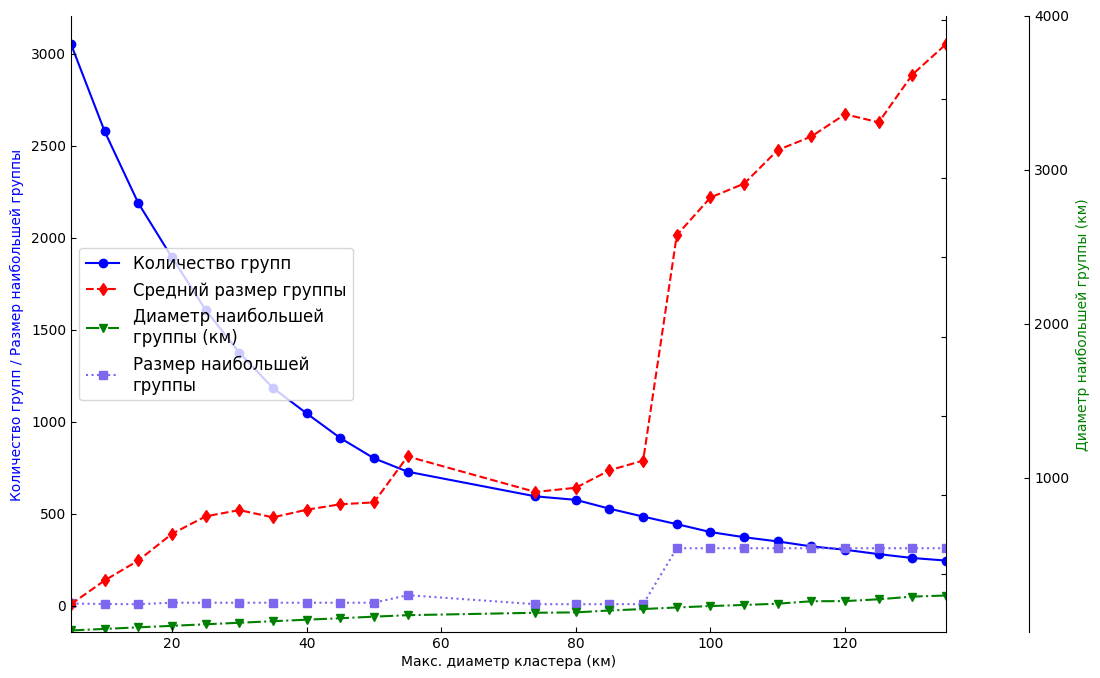

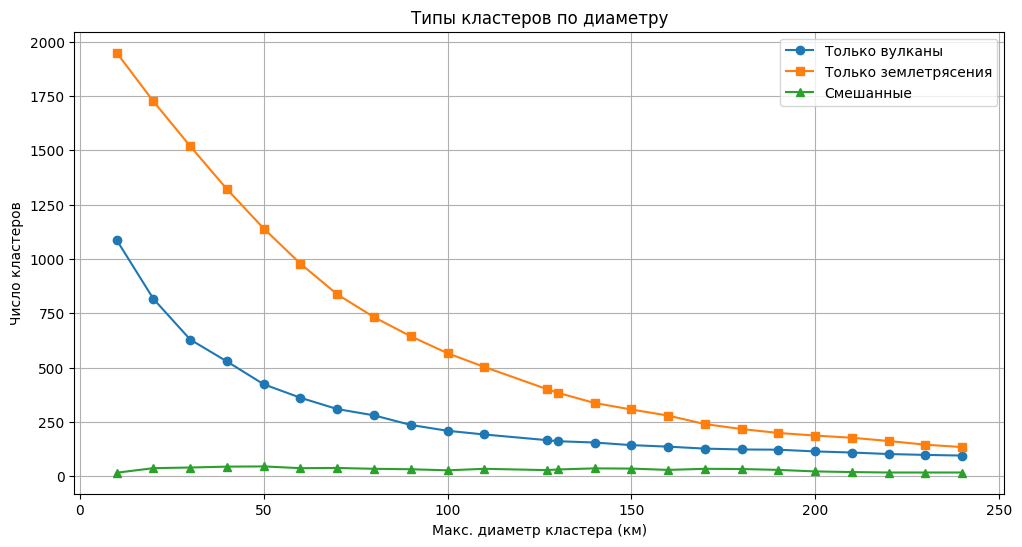

In [5]:
# --- PARAMETERS ---
#MAX_DISTANCE_KM = 200  # discard volcano–earthquake pairs farther than this
#K_NEAREST = 3  # for each earthquake, consider only k nearest volcanoes (to reduce number of pairs)
#DIAMETER_SCALE = 1000  # scale factor for diameter when plotting (e.g., km to 1000 km)

# --- Language translation: 'en' or 'ru' ---
def tr(en_text: str, ru_text: str) -> str:
    return ru_text if LANGUAGE == 'ru' else en_text

import csv
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from sklearn.metrics.pairwise import haversine_distances
from mpl_toolkits.axisartist import Subplot as AA
from mpl_toolkits.axes_grid1 import host_subplot
import folium

# --- Helper functions ---
def parse_coords(coord_string):
    lon, lat = map(float, coord_string.replace("Point(", "").replace(")", "").split())
    return (lat, lon)

def compute_group_diameter(coords):
    if len(coords) < 2:
        return 0
    dist_matrix = haversine_distances(np.radians(coords)) * 6371.0
    return np.max(dist_matrix)

def transform_x(x, compress_before, compress_between, compress_after):
    if x < 120:
        return x * compress_before
    elif 120 <= x <= 130:
        return 120 * compress_before + (x - 120) * compress_between
    else:
        return 120 * compress_before + 10 * compress_between + (x - 130) * compress_after

# --- Load data ---
volcano_coords = []
earthquake_coords = []

with open(f_volcano, encoding='utf-8', newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=",")
    for row in reader:
        coord = parse_coords(row['location'])
        volcano_coords.append(coord)

with open(f_earthquake, encoding='utf-8', newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=",")
    for row in reader:
        coord = parse_coords(row['location'])
        earthquake_coords.append(coord)

all_coords = volcano_coords + earthquake_coords
types = ['volcano'] * len(volcano_coords) + ['earthquake'] * len(earthquake_coords)
tree = KDTree(np.radians(all_coords))

# --- New clustering by max diameter ---

groups_count_list = []
average_group_size_list = []
largest_group_size_list = []
largest_group_diameter_list = []
volcano_only_list = []
earthquake_only_list = []
mixed_list = []

all_clusters_by_d = {}

for i, d_max in enumerate(cluster_diameter_max_list):
    print(f"[{i+1}/{len(cluster_diameter_max_list)}] Diameter max = {d_max} км")
    G = nx.Graph()
    for idx, coord in enumerate(all_coords):
        G.add_node(idx, pos=coord, type=types[idx])

    for idx, coord in enumerate(all_coords):
        indices = tree.query_ball_point(np.radians(coord), r=d_max / 6371.0)
        for neighbor_idx in indices:
            if neighbor_idx != idx:
                G.add_edge(idx, neighbor_idx)

    connected_components = []
    for group in nx.connected_components(G):
        coords = [all_coords[idx] for idx in group]
        diameter = compute_group_diameter(coords)
        if diameter <= d_max:
            connected_components.append(group)

    group_sizes = [len(group) for group in connected_components]
    group_diameters = [compute_group_diameter([all_coords[idx] for idx in group]) for group in connected_components]

    groups_count_list.append(len(connected_components))
    average_group_size_list.append(np.mean(group_sizes) if group_sizes else 0)
    largest_group_size_list.append(np.max(group_sizes) if group_sizes else 0)
    largest_group_diameter_list.append(np.max(group_diameters) if group_diameters else 0)

    # Cluster type stats
    volcano_only = 0
    earthquake_only = 0
    mixed = 0
    for group in connected_components:
        labels = {types[idx] for idx in group}
        if labels == {'volcano'}:
            volcano_only += 1
        elif labels == {'earthquake'}:
            earthquake_only += 1
        else:
            mixed += 1
    volcano_only_list.append(volcano_only)
    earthquake_only_list.append(earthquake_only)
    mixed_list.append(mixed)

    if d_max == 127:
        all_clusters_by_d[127] = connected_components

# --- Interactive map for d=127 ---
map_127 = folium.Map(location=[0, 0], zoom_start=2)
for group in all_clusters_by_d[127]:
    coords = [all_coords[idx] for idx in group]
    lat_lon = np.array(coords)
    centroid = lat_lon.mean(axis=0)
    diameter = compute_group_diameter(coords)

    for idx in group:
        color = 'red' if types[idx] == 'volcano' else 'black'
        folium.CircleMarker(location=all_coords[idx], radius=3, color=color, fill=True, fill_opacity=0.8).add_to(map_127)

    folium.Circle(location=centroid, radius=(diameter/2)*1000, color='gray', weight=1, dash_array='5,10', fill=False).add_to(map_127)

map_127

# --- Plot main metrics ---
new_x_list = [transform_x(x, 0.5, 2.0, 0.5) for x in cluster_diameter_max_list]
real_to_new_x = dict(zip(cluster_diameter_max_list, new_x_list))

plt.rcParams["axes.grid"] = False
fig = plt.figure(figsize=(14, 8))
host = host_subplot(111, axes_class=AA)
plt.subplots_adjust(right=0.75)
host.axis["top"].set_visible(False)
par1 = host.twinx()
par2 = host.twinx()
par2.axis["right"] = par2.get_grid_helper().new_fixed_axis(loc="right", axes=par2, offset=(60, 0))
par2.axis["right"].toggle(all=True)

p1, = host.plot(new_x_list, groups_count_list, marker='o', label="Number of Groups", color='blue')
p2, = host.plot(new_x_list, largest_group_size_list, marker='s', linestyle=':', label="Largest Group Size", color='mediumslateblue')
p3, = par1.plot(new_x_list, average_group_size_list, marker='d', linestyle='--', label="Average Group Size", color='red')
scaled_largest_diameter = [x/1000 for x in largest_group_diameter_list]
p4, = par2.plot(new_x_list, scaled_largest_diameter, marker='v', linestyle='-.', label="Largest Group Diameter (km)", color='green')

host.set_xlim(min(new_x_list), max(new_x_list))
host.set_xlabel(tr("Max Cluster Diameter (km)", "Макс. диаметр кластера (км)"), fontsize=14)
host.axis["left"].label.set_color("blue")
host.set_ylabel(tr("Number of Groups / Largest Group Size", "Количество групп / Размер наибольшей группы"), fontsize=14)
par1.set_ylabel(tr("Average Group Size", "Средний размер группы"), fontsize=14)
par1.axis["right"].label.set_color("red")
par2.set_ylabel(tr("Largest Group Diameter (km)", "Диаметр наибольшей группы (км)"), fontsize=14)
par2.axis["right"].label.set_color("green")
par2.set_yticks([1, 2, 3, 4])
par2.set_yticklabels(["1000", "2000", "3000", "4000"], color='green')
host.legend([p1, p3, p4, p2], [tr("Number of Groups", "Количество групп"), tr("Average Group Size", "Средний размер группы"), tr("Largest Group\nDiameter (km)", "Диаметр наибольшей\nгруппы (км)"), tr("Largest Group Size", "Размер наибольшей\nгруппы")], loc='center left', fontsize=12)
plt.show()

# --- Plot type-specific cluster counts ---
plt.figure(figsize=(12, 6))
plt.plot(cluster_diameter_max_list, volcano_only_list, label=tr("Volcano-only clusters", "Только вулканы"), marker='o')
plt.plot(cluster_diameter_max_list, earthquake_only_list, label=tr("Earthquake-only clusters", "Только землетрясения"), marker='s')
plt.plot(cluster_diameter_max_list, mixed_list, label=tr("Mixed clusters", "Смешанные"), marker='^')
plt.xlabel(tr("Max Cluster Diameter (km)", "Макс. диаметр кластера (км)"))
plt.ylabel(tr("Number of Clusters", "Число кластеров"))
plt.legend()
plt.grid(True)
plt.title(tr("Cluster Types by Diameter Threshold", "Типы кластеров по диаметру"))
plt.show()